# Introduction

Gun ownership in the United States of America (USA) is legal and constitutionally protected by the United States Bill of Rights. The Second Amendment of the United States Constitution states that "A well regulated Militia, being necessary to the security of a free State, the right of the people to keep and bear Arms, shall not be infringed." This amendment protects the right of law-abiding citizens to use firearms as a tool of self-defence. However, the circulation and possesion of firearms also poses an increased potential hazard to the life and wellbeing American citizens, as accidental or intentional discharges can imperil their lives. Consequently, a series of gun laws have been enacted throughout the years to prevent gun violence incidents from occuring.

The present notebook aims to analyse gun violence trends in the United States from January 2013 to March 2018, as well as the efficacy of gun laws throughout this period. The data used throughout this notebook has been obtained from the Gun Violence Archive (GVA), and made available by James Ko. GVA is a non-profit research group founded in 2013, whose goal is to provide accurate information about gun violence incidents to the public. The data is collected from over 6,500 law enforcement, media, government and commercial sources daily, and uploaded to their website(https://gunviolencearchive.org) in real-time, as well as used for statistics on their social platforms. GVA does not have any affiliation with an organisation or political party.

# Data Cleaning

The data provided by GVA contains 239,677 recorded incidents from January 2013 to March 2018, presented in increasing chronological order. The dataset exhibits information about the time, location, and participants of the event, as well as sources to confirm its veridicality. The features presented in the dataset, together with their corresponding data type, are as follows:

1. address
2. city_or_county 	
3. congressional_district 	
4. date 	
5. gun_stolen 	
6. gun_type 	
7. incident_characteristics 	
8. incident_id 	
9. incident_url 	
10. incident_url_fields_missing 	
11. latitude 	
12. location_description 	
13. longitude 	
14. n_guns_involved 	
15. n_injured 	
16. n_killed 	
17. notes 	
18. participant_age 	
19. participant_age_group 	
20. participant_gender 	
21. participant_name 	
22. participant_relationship 	
23. participant_status 	
24. participant_type 	
25. source_url 	
26. sources 	
27. state 	
28. state_house_district 	
29. state_senate_district

The number of casualties ranges from 0 to 50 for deaths, and 0 to 53 for injuries respectively. Both values show a relatively high positive skewness (4.4 and 6.6), revealing that incidents with few casualties are more frequent than those with a high number of casualties. Incidents may involve from 1 to 400 guns, although the analysis suggests that the number of guns involved is highly skewed in the favour of low number of guns.

The data presents an invariate number of missing values for each feature, most notably for participant_relationship and location_description, where 93.4% and 82.4% are missing; other features have 51% or less missing fields. In terms of uniqueness, what stands out is that only 96.65% of the names are unique, meaning that some participants could potentially be involved in more than one incidents. Moreover, only 88.73% of the crimes have a unique address, which suggests that some locations might have a history of gun violence incidents.

As notified by James Ko, the Las Vegas mass shooting incident from 2017 is missing from the original dataset. A separate .csv file is then provided and merged to the data.

In order to carry on with the analysis participant features need to be formatted from the original strings into dictionaries. Furthermore, separation of victims and suspects is desired.


In [40]:
import pandas as pd
import numpy as np
import Levenshtein as lev
import random
from scipy.stats import skew
import missingno as msno

from datetime import datetime as dt
import data_exploration as de

import warnings
warnings.filterwarnings("ignore")

In [41]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [42]:
data = pd.read_csv("gun-violence-data_01-2013_03-2018.csv")

In [43]:
# Add the Las Vegas shooting incident from 2017
lv_incident = pd.read_csv("las-vegas-1-10-2017.csv")
data = pd.concat([data, lv_incident])

In [44]:
data.head(3)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,14.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,NaN,-79.8559,NaN,Julian Sims under investigation: Four Shot and...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,43.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,NaN,-118.3330,NaN,Four Shot; One Killed; Unidentified shooter in...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,9.0,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,Cotton Club,-82.1377,2.0,NaN,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0


In [45]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
incident_id,239678.0,559335.961745,293129.139541,92114.0000,308546.5000,543588.5000,817230.25000,1.083472e+06
n_killed,239678.0,0.252535,0.535399,0.0000,0.0000,0.0000,0.00000,5.900000e+01
n_injured,239678.0,0.495844,1.158636,0.0000,0.0000,0.0000,1.00000,4.410000e+02
congressional_district,227734.0,8.001234,8.480829,0.0000,2.0000,5.0000,10.00000,5.300000e+01
latitude,231755.0,37.546592,5.130753,19.1114,33.9034,38.5706,41.43735,7.133680e+01
longitude,231755.0,-89.338460,14.359615,-171.4290,-94.1588,-86.2496,-80.04865,9.743310e+01
n_guns_involved,140227.0,1.372767,4.679772,1.0000,1.0000,1.0000,1.00000,4.000000e+02
state_house_district,200905.0,55.447132,42.048117,1.0000,21.0000,47.0000,84.00000,9.010000e+02
state_senate_district,207342.0,20.477110,14.204560,1.0000,9.0000,19.0000,30.00000,9.400000e+01


In [46]:
de.missing_values_table(data)

,participant_relationship,location_description,participant_name,gun_stolen,gun_type,n_guns_involved,participant_age,notes,participant_age_group,state_house_district,participant_gender,state_senate_district,participant_status,participant_type,address,congressional_district,latitude,longitude,sources,source_url,incident_characteristics,incident_url_fields_missing,incident_url,n_injured,n_killed,city_or_county,state,date,incident_id
Missing,"223,904","197,588","122,253","99,498","99,451","99,451","92,298","81,017","42,119","38,773","36,362","32,336","27,626","24,863","16,497","11,944","7,923","7,923",609,468,326,0,0,0,0,0,0,0,0
Percentage,93.42,82.44,51.01,41.51,41.49,41.49,38.51,33.8,17.57,16.18,15.17,13.49,11.53,10.37,6.88,4.98,3.31,3.31,0.25,0.2,0.14,0,0,0,0,0,0,0,0


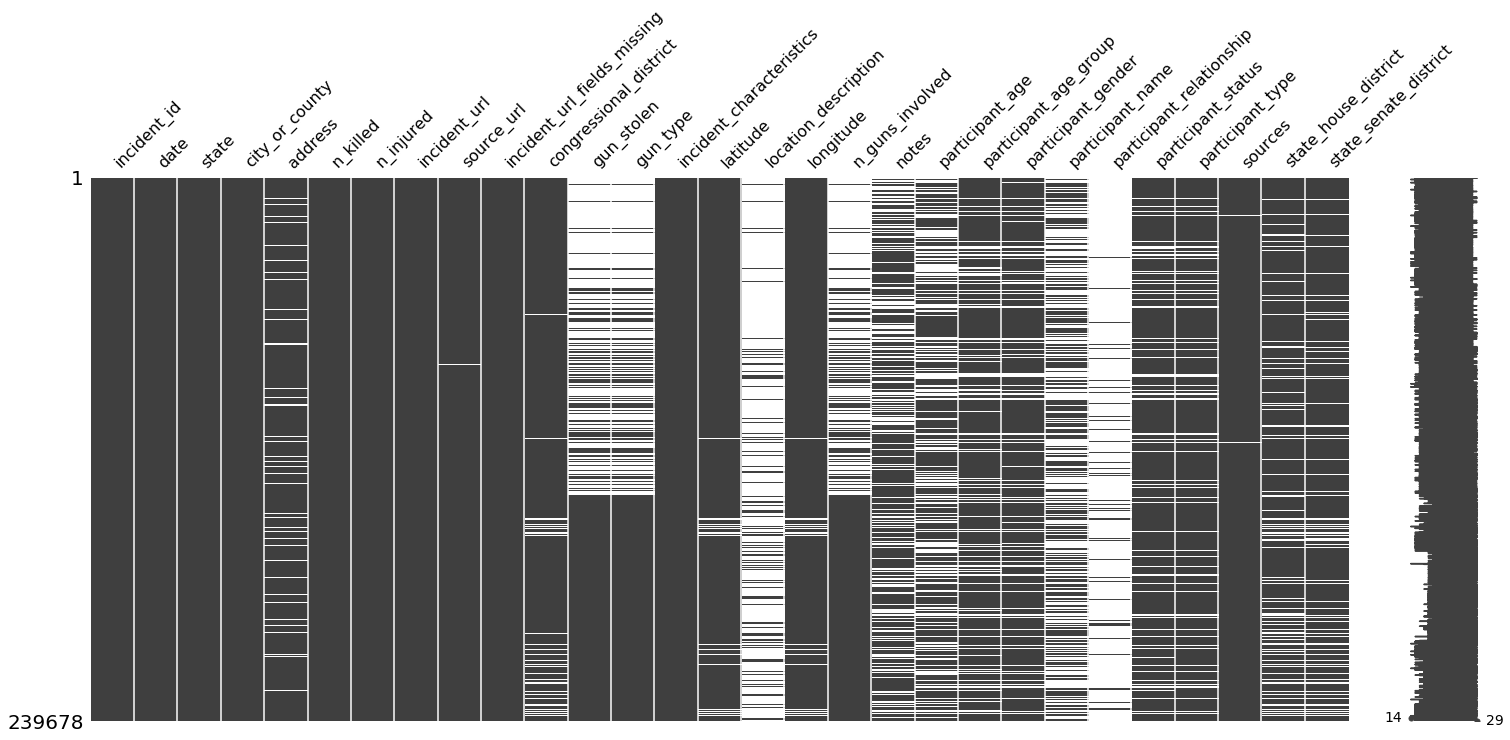

In [47]:
%matplotlib inline
msno.matrix(data)

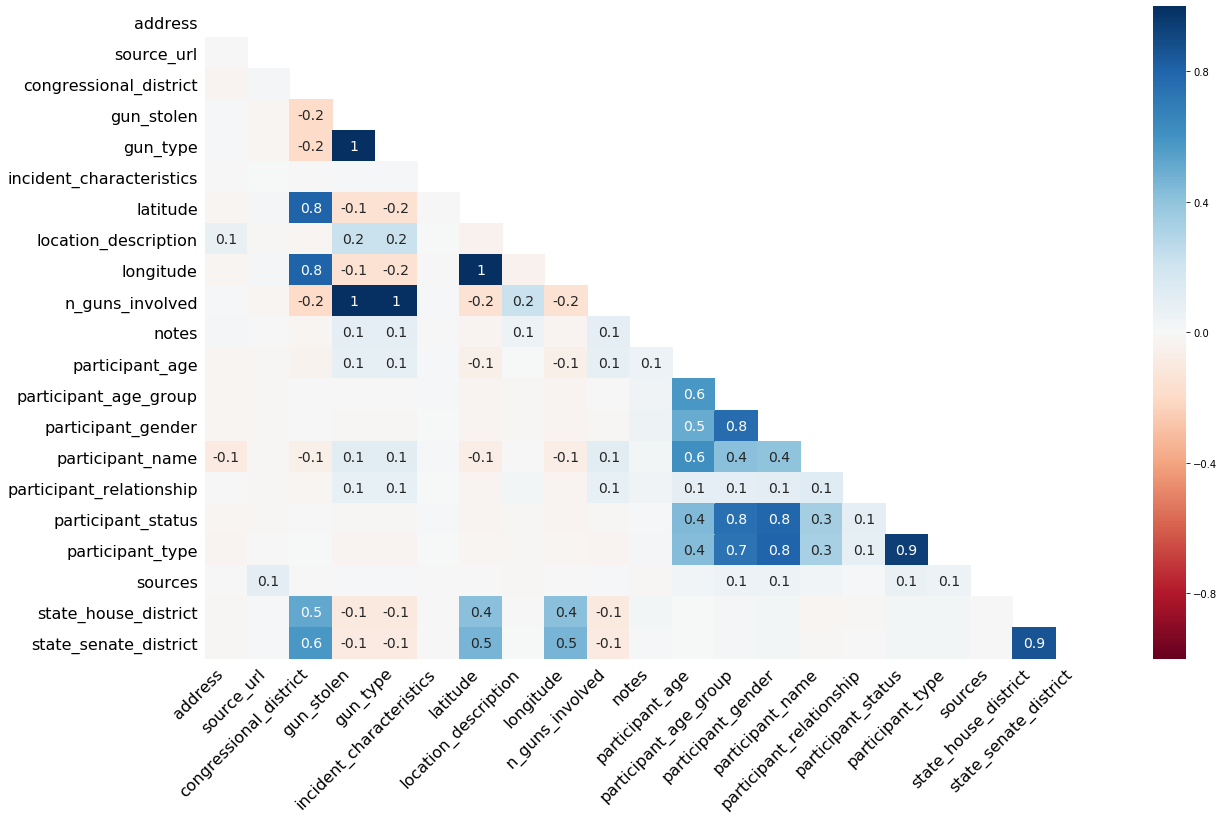

In [48]:
msno.heatmap(data)

In [49]:
de.unique_values_table(data)

,address,city_or_county,congressional_district,date,gun_stolen,gun_type,incident_characteristics,incident_id,incident_url,incident_url_fields_missing,latitude,location_description,longitude,n_guns_involved,n_injured,n_killed,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,source_url,sources,state,state_house_district,state_senate_district
Unique,"198,038","12,898",54,"1,726",350,"2,502","18,127","239,678","239,678",1,"101,240","27,595","112,348",106,24,17,"136,653","18,952",899,874,"113,489",284,"2,151",260,"213,990","217,281",51,275,68
Percentage,88.73,5.38,0.02,0.72,0.25,1.78,7.57,100,100,0,43.68,65.56,48.48,0.08,0.01,0.01,86.13,12.86,0.46,0.43,96.65,1.8,1.01,0.12,89.46,90.89,0.02,0.14,0.03


In [50]:
pd.DataFrame(data.dtypes, columns=["Type"]).T

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
Type,int64,object,object,object,object,int64,int64,object,object,bool,float64,object,object,object,float64,object,float64,float64,object,object,object,object,object,object,object,object,object,float64,float64


In [51]:
pd.DataFrame(data.skew(), columns=["Skewness"]).T

,incident_id,n_killed,n_injured,incident_url_fields_missing,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
Skewness,0.09516,11.653406,230.399815,0.0,2.106365,0.207232,-1.35481,51.549201,1.822479,0.638406


In [52]:
pd.DataFrame(data.kurt(), columns=["Kurtosis"]).T

,incident_id,n_killed,n_injured,incident_url_fields_missing,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
Kurtosis,-1.224179,956.853784,87195.875552,0.0,5.169622,1.878919,2.530791,3569.649547,17.431432,-0.244244


In [53]:
# TODO correlations: pearson's r, spearman's p, kendall's t, phik, cramer's v

In [54]:
data.set_index("incident_id", inplace=True)
data = data.drop(["incident_url_fields_missing", "incident_url", "source_url", "sources"], axis=1)

In [55]:
data["date"] = pd.to_datetime(data["date"])
data = data.sort_values(by=["date"])
data = data[['date', 'state', 'city_or_county', 'address', 'location_description', 'n_killed', 'n_injured', 'incident_characteristics', 'n_guns_involved', 'gun_stolen', 'gun_type', 'notes', 'participant_name', 'participant_age', 'participant_age_group', 'participant_gender', 'participant_status', 'participant_type', 'participant_relationship']]

In [56]:
pd.date_range(start = '2014-01-01', end = '2018-03-31' ).difference(data.date)

DatetimeIndex(['2015-04-21', '2016-06-17', '2017-01-24'], dtype='datetime64[ns]', freq=None)

In [59]:
# Convert participant info into Python data structures (dictionary/list)
data[["suspect_name", "suspect_age", "suspect_age_group", "suspect_gender", "suspect_status", "n_suspects"]] = pd.DataFrame([[np.nan for _ in range(6)] for _ in range(data.shape[0])], index=data.index)
for col in ['gun_stolen', 'gun_type', 'participant_name', 'participant_age', 'participant_age_group', 'participant_gender', 'participant_relationship', 'participant_status', 'participant_type']:
    data[col] = data[col].apply(de.split_into_dict)
data['participant_age'] = data['participant_age'].apply(de.convert_vals_to_int)
data['incident_characteristics'] = data['incident_characteristics'].apply(de.split_into_list)

In [80]:
age_groups = set(); statuses = set(); relationships = set()
for row in data.values:
    if pd.notnull(row[data.columns.get_loc("participant_age_group")]):
        for k, v in row[data.columns.get_loc("participant_age_group")].items():
            age_groups.add(v)
    if pd.notnull(row[data.columns.get_loc("participant_status")]):
        for k, v in row[data.columns.get_loc("participant_status")].items():
            statuses.add(v) 
    if pd.notnull(row[data.columns.get_loc("participant_relationship")]):
        for k, v in row[data.columns.get_loc("participant_relationship")].items():
            relationships.add(v)  
            
print(" -- Participant age groups:\n" + str(age_groups))
print(" -- Participant statuses:\n" + str(statuses))
print(" -- Victim-suspect relationships:\n" + str(relationships))

 -- Participant age groups:
{'Adult 18+', 'Teen 12-17', 'Child 0-11', 'Teen (12-17)'}
 -- Participant statuses:
{'Killed, Injured', 'Killed, Unharmed, Arrested', 'Killed, Unharmed', 'Unharmed', 'Arrested', 'Killed', 'Injured, Unharmed, Arrested', 'Killed, Arrested', 'Injured', 'Unharmed, Arrested', 'Injured, Unharmed', 'Injured, Arrested'}
 -- Victim-suspect relationships:
{'Mass shooting - Random victims', 'Mass shooting - Perp Knows Victims', 'Neighbor', 'Family', 'Home Invasion - Perp Knows Victim', 'Significant others - current or former', 'Co-worker', 'Aquaintance', 'Friends', 'Gang vs Gang', 'Home Invasion - Perp Does Not Know Victim', 'Armed Robbery', 'Drive by - Random victims'}


In [81]:
data_list = data.values
data = de.populate_suspect_columns(data)

data["participant_type"] = data["participant_type"].apply(lambda x: de.replace_dict(x))
data.rename(columns = {"participant_type": "n_victims"}, inplace = True)
data.rename(columns = {"participant_relationshiop": "victim_suspect_relationship"}, inplace = True)

# Change the name of columns from participant_ to victim_
for suffix in ["name", "age", "age_group", "gender", "relationship", "status"]:
    data.rename(columns = {"participant_" + suffix: "victim_" + suffix}, inplace = True)

In [80]:
# Function to remove house/street numbers from address
def clean_unique_address(address):
    # Remove orders
    address = re.sub('([0-9]*th|[0-9]*1st|[0-9]*2nd|[0-9]*3rd)', ' ', address)
    # Remove digits
    address = re.sub('[0-9]*', '', address)
    # Remove cardinal points
    address = re.sub('N |E |S |W |NE|NW|SE|SW', ' ', address)
    # Clean whitespaces
    address = clean_whitespaces(address)
    return address

In [81]:
# Compare addresses only after removing numbers to ensure that the dissimilarity is not caused by houses/streets of different numbers
lev_addresses = dict()
for item in list(set(data[pd.notnull(data['Address'])]["Address"].apply(clean_address_string))):
    lev_addresses[index] = clean_unique_address(item)
    index += 1

In [83]:
# Sample 1% of the addresses
lev_addresses = dict(random.sample(lev_addresses.items(), 1884))

In [443]:
# Find combinations of addresses that have between 0.95 and 0.99 similarity, disregarding numbers of streets and cardinals
for sampled_address in sample_lev_addresses.keys():
    for address in unique_addresses.keys():
        similarity = lev.ratio(lev_addresses[sampled_address], lev_addresses[address])
        if similarity*100 in range(95, 100):
            print("There is a similarity of " + str(similarity) + " between the following strings:")
            print(" 1. " + unique_addresses[sampled_address])
            print(" 2. " + unique_addresses[address])

There is a similarity of 0.95 between the following strings:
 1. 1800 block of Amber Drive
 2. 3000 block of Ember Drive
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. 1812 W Clarke Street
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. 1820 W Clarke Street
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. Clarke Street
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. 1617 W Clarke Street
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. 3900 Clarke Street
There is a similarity of 0.95 between the following strings:
 1. 1000 block of Eagle Drive
 2. 1950 block of Cagle Drive
There is a similarity of 0.96 between the following strings:
 1. 202 W Baker Street
 2. 185 Barker Street
There is a similarity of 0.96 between the following strings:
 1. 202 W Baker Street
 2. 75 Barker Street
There is a similarity of 0.96 b

There is a similarity of 0.96 between the following strings:
 1. 304 Waters Avenue
 2. S Water Avenue
There is a similarity of 0.96 between the following strings:
 1. 304 Waters Avenue
 2. Water Avenue
There is a similarity of 0.96 between the following strings:
 1. 304 Waters Avenue
 2. NW Water Avenue
There is a similarity of 0.96 between the following strings:
 1. 6400 block of S Claremont Avenue
 2. 2900 block of Clairmont Avenue
There is a similarity of 0.95 between the following strings:
 1. 2200 block of Poland Road
 2. 8300 block of Noland Road
There is a similarity of 0.95 between the following strings:
 1. 2200 block of Poland Road
 2. 9700 block of Noland Road
There is a similarity of 0.95 between the following strings:
 1. 2200 block of Poland Road
 2. 1100 block of N Noland Road
There is a similarity of 0.95 between the following strings:
 1. 1100 block of Oster Drive
 2. 100 block of Otero Drive
There is a similarity of 0.95 between the following strings:
 1. 1100 block o

There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 300 block of Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 2600 block of Martin Luther King Jr Boulevard SW
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 100 block of Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 300 block of N Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 800 block of S Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 600 block of Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following stri

There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 10300 block of Edes Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 8400 block of Edes Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 2300 block of Edna Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 5900 block of Edna Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 9800 block of Edes Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 10400 block of Edes Avenue
There is a similarity of 0.96 between the following strings:
 1. 615 N Hawley Street
 2. Haley Street
There is a similarity of 0.96 between the following strings:
 1. 512 S Kings Highway
 2. 5937 King Highway
There is a similarity of 0.96 between the following strings:
 1

There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 3100 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 200 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 1700 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 10000 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 400 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 3400 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 1100 block of E High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 900 block of High

There is a similarity of 0.96 between the following strings:
 1. 6422 Storer Avenue
 2. 92 Store Avenue
There is a similarity of 0.95 between the following strings:
 1. 1800 block of Pryor Street
 2. 4200 block of Pro Street
There is a similarity of 0.95 between the following strings:
 1. 1500 block of SW Polk Street
 2. 300 block of Folk Street
There is a similarity of 0.96 between the following strings:
 1. Cricket Lane
 2. 20 Crickett Lane
There is a similarity of 0.96 between the following strings:
 1. Elliot Street
 2. 36 Eliot Street
There is a similarity of 0.95 between the following strings:
 1. 500 block of Iowa Avenue
 2. 3200 block of Iola Avenue
There is a similarity of 0.96 between the following strings:
 1. 1214 Baker Avenue
 2. 4969 N Backer Avenue
There is a similarity of 0.96 between the following strings:
 1. 1214 Baker Avenue
 2. N Backer Avenue
There is a similarity of 0.96 between the following strings:
 1. 1214 Baker Avenue
 2. 273 Barker Avenue
There is a similar

In [82]:
data['address'] = data['address'].apply(de.clean_address_string)

In [83]:
print("Total number of incidents recorded in 2013: \t"+ str(len(data[data["date"].dt.year == 2013])))
print("Average number of incidents recorded (2014-17): " + str(round(len(data[data["date"].dt.year.between(2014, 2018)]) / 4)))

Total number of incidents recorded in 2013: 	278
Average number of incidents recorded (2014-17): 59850


In [84]:
victims_2013 = de.victims_by_year(data, 2013)

In [85]:
# TODO calculate mass shootings by looking at incidents
print("Total number of mass shootings in 2013: " + str(len([nr_victims for nr_victims in victims_2013 if nr_victims >= 4])))
print("Total number of incidents in 2013: \t" + str(len(victims_2013)))

Total number of mass shootings in 2013: 151
Total number of incidents in 2013: 	278


In [86]:
# Create a mass shooting dataset for further analysis an remove the 2013 incidents from the dataset
mass_shootings = data[(data["n_killed"] + data["n_injured"] - data["n_suspects"]) >= 4]
data = data[data["date"].dt.year != 2013]

# Data Visualisation

## Date

In [88]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from dateutil import rrule
import calendar
import collections
from collections import Counter
from datetime import timedelta as td
from itertools import islice
import altair as alt

mpl.style.use('default')

In [72]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
          'October', 'November', 'December']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
holidays = {"New Year's Day": dt(2000, 1, 1), "Martin Luther King, Jr. Day": dt(2000, 1, 21), 
            "George Washington’s Birthday": dt(2000, 2, 18), "Memorial Day": dt(2000, 5, 27),
            "Independence Day": dt(2000, 7, 4), "Labor Day": dt(2000, 9, 2), "Columbus Day": dt(2000, 10, 14),
            "Veterans Day": dt(2000, 11, 11), "Thanksgiving Day": dt(2000, 11, 28), "Christmas Day": dt(2000, 12, 25)}

### Number of casualties per year (2014-2018)

In [73]:
n_killed_by_year = data.groupby(data.date.dt.year).sum().loc[:, "n_killed"]
n_injured_by_year = data.groupby(data.date.dt.year).sum().loc[:, "n_injured"]
n_incidents_by_year = data.groupby(data.date.dt.year).count().loc[:, "date"]

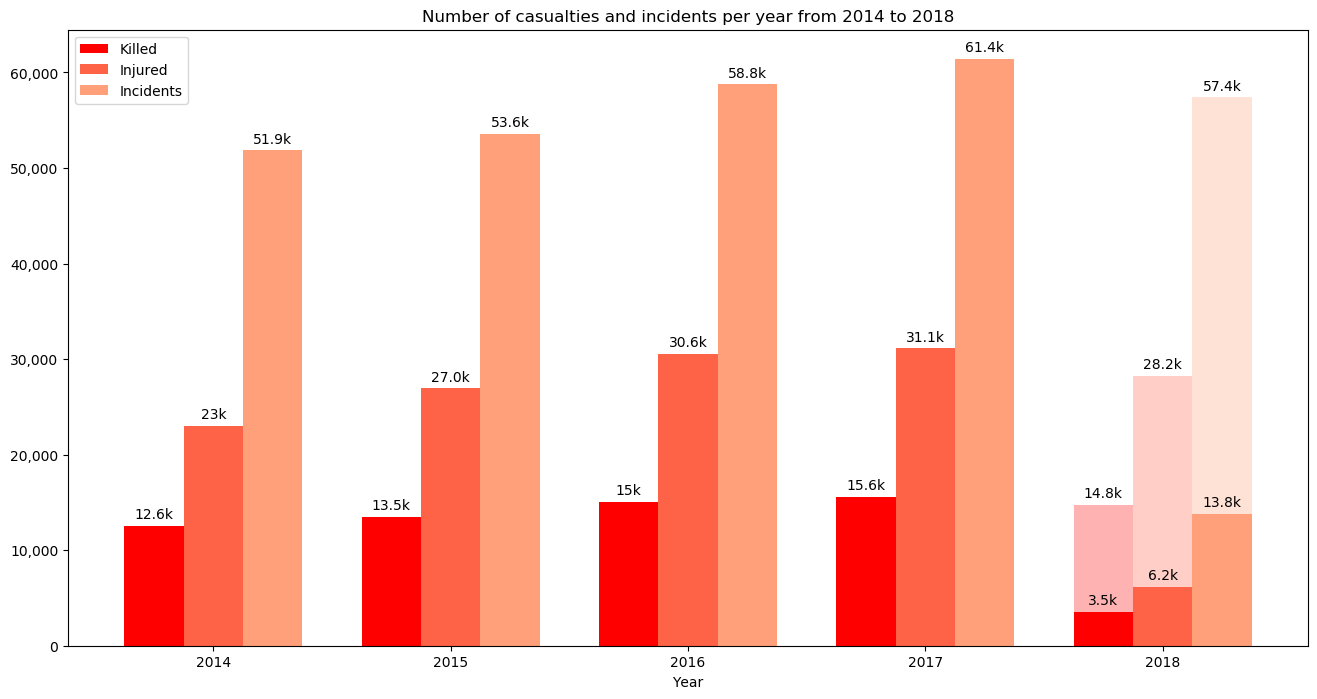

In [74]:
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.25
bars = []
bars.append(ax.bar(np.arange(len(n_killed_by_year)) - bar_width, list(n_killed_by_year), bar_width, label='Killed', align='center', color='r'))
bars.append(ax.bar(np.arange(len(n_injured_by_year)), list(n_injured_by_year), bar_width, label='Injured', align='center', color='tomato'))
bars.append(ax.bar(np.arange(len(n_incidents_by_year)) + bar_width, list(n_incidents_by_year), bar_width, label='Incidents', align='center', color='lightsalmon'))
# True values for 2018
bars.append(ax.bar(np.arange(len(n_killed_by_year)) - bar_width, [0] * 4 + [14777], bar_width, alpha=0.3, align='center', color='r'))
bars.append(ax.bar(np.arange(len(n_injured_by_year)), [0] * 4 + [28234], bar_width, alpha=0.3, align='center', color='tomato'))
bars.append(ax.bar(np.arange(len(n_incidents_by_year)) + bar_width, [0] * 4 + [57386], bar_width, alpha=0.3, align='center', color='lightsalmon'))
# Function to provide number represented by the bars on top
def toplabel(bars):
    for bar in bars:
        height = bar.get_height()
        if height != 0:
            if int(height/100) % 10 == 0:
                ax.annotate("{}k".format(int(height / 1000)), xy=(bar.get_x() + bar.get_width()/2, height), 
                            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
            else:
                ax.annotate("{:.1f}k".format(height / 1000), xy=(bar.get_x() + bar.get_width()/2, height), 
                            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
for bar in bars:
    toplabel(bar)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Year")
plt.xticks(range(len(n_killed_by_year)), list(n_killed_by_year.index))
plt.legend(loc='upper left')
plt.title("Number of casualties and incidents per year from 2014 to 2018")
plt.show()

### Number of incidents by month (2014-2018)

In [89]:
n_incidents_by_month = data.groupby([data.date.dt.year, data.date.dt.month]).count().loc[:,"date"]
# Divide number of incidents for each month by the number of days
for date in rrule.rrule(rrule.MONTHLY, dtstart=dt(2014, 1, 1), until=dt(2018, 3, 1)):
    n_incidents_by_month[date.year][date.month] = n_incidents_by_month[date.year][date.month] / calendar.monthrange(date.year, date.month)[1]
# Average month values over all years
incidents_by_month_ave = pd.DataFrame(n_incidents_by_month).groupby(n_incidents_by_month.index.get_level_values(1)).sum() // pd.DataFrame(n_incidents_by_month).groupby(n_incidents_by_month.index.get_level_values(1)).count()

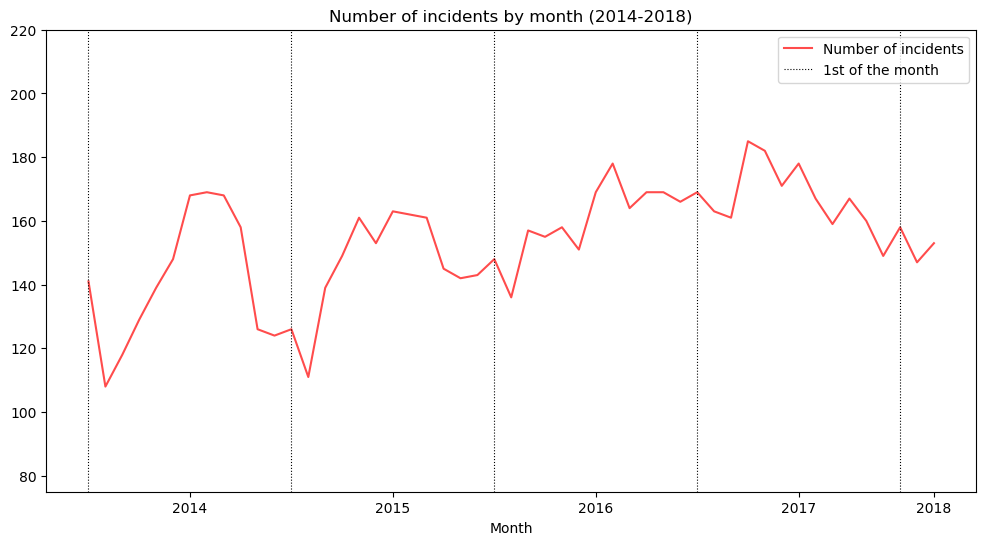

In [76]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(n_incidents_by_month)), list(n_incidents_by_month), label='Number of incidents', alpha=0.7, color='red')
ax.set_xlabel("Month")
ax.set_ylim([75, 220])
plt.setp(ax, xticks=[6, 18, 30, 42, 50], xticklabels=['2014', '2015', '2016', '2017', '2018'])
for month in range(0, 51, 12):
    mline = ax.axvline(month, color='black', linestyle=':', linewidth=0.8)
mline.set_label('1st of the month')
plt.title("Number of incidents by month (2014-2018)")
plt.legend(loc='upper right')
plt.show()

### Average number of incidents by month

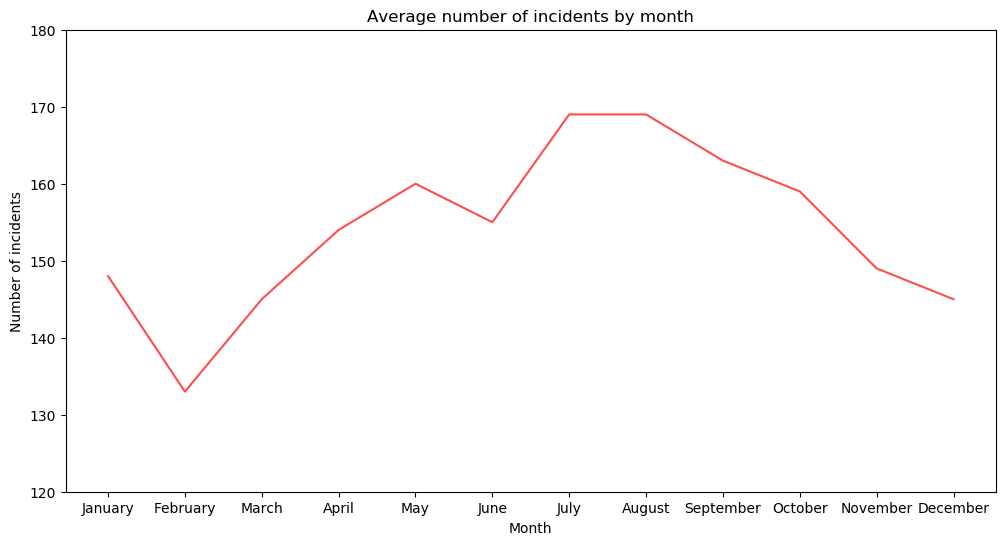

In [77]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(12), incidents_by_month_ave, label='Incidents', alpha=0.7, color='red')
ax.set_ylabel("Number of incidents")
ax.set_xlabel("Month")
ax.set_ylim([120, 180])
plt.xticks(range(len(incidents_by_month_ave)), map(lambda x: calendar.month_name[x], incidents_by_month_ave.index))
plt.title("Average number of incidents by month")
plt.show()

### Average number of incidents by date

In [78]:
n_incidents_by_date = data.groupby(data.date.dt.date).count().loc[:, "date"]
# Average date values over all years
n_records_by_date = pd.DataFrame(data.groupby([data.date.dt.year, data.date.dt.month, data.date.dt.day, data.date.dt.weekday]).count().loc[:, "date"])
n_avg_killed_by_date = pd.DataFrame(data.groupby([data.date.dt.month, data.date.dt.day]).sum().loc[:, "n_killed"]) // n_records_by_date.groupby([n_records_by_date.index.get_level_values(1), n_records_by_date.index.get_level_values(2)]).count().rename(columns={"date":"n_killed"})
n_avg_injured_by_date = pd.DataFrame(data.groupby([data.date.dt.month, data.date.dt.day]).sum().loc[:, "n_injured"]) // n_records_by_date.groupby([n_records_by_date.index.get_level_values(1), n_records_by_date.index.get_level_values(2)]).count().rename(columns={"date":"n_injured"})
n_avg_incidents_by_date = pd.DataFrame(data.groupby([data.date.dt.month, data.date.dt.day]).count().loc[:, "date"]) // n_records_by_date.groupby([n_records_by_date.index.get_level_values(1), n_records_by_date.index.get_level_values(2)]).count()

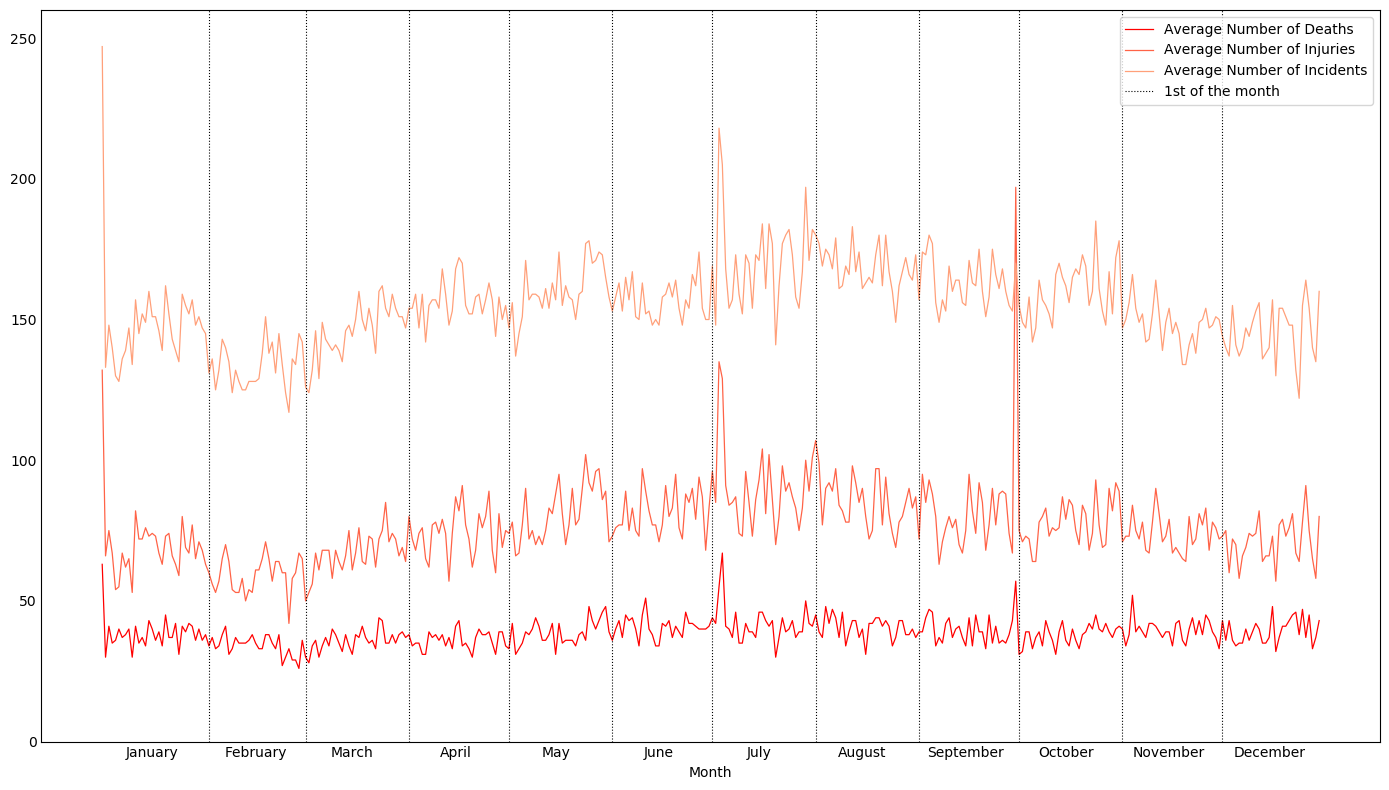

In [79]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(np.arange(366), n_avg_killed_by_date, label='Average Number of Deaths', color='red', linewidth=0.9)
ax.plot(np.arange(366), n_avg_injured_by_date, label='Average Number of Injuries', color='tomato', linewidth=0.9)
ax.plot(np.arange(366), n_avg_incidents_by_date, label='Average Number of Incidents', color='lightsalmon', linewidth=0.9)
ax.set_ylim([0, 260])
ax.set_xlabel("Month")
plt.setp(ax, xticks=[dt(2000, 1, 15).timetuple().tm_yday, dt(2000, 2, 15).timetuple().tm_yday, dt(2000, 3, 15).timetuple().tm_yday, dt(2000, 4, 15).timetuple().tm_yday, dt(2000, 5, 15).timetuple().tm_yday, dt(2000, 6, 15).timetuple().tm_yday, dt(2000, 7, 15).timetuple().tm_yday, dt(2000, 8, 15).timetuple().tm_yday, dt(2000, 9, 15).timetuple().tm_yday, dt(2000, 10, 15).timetuple().tm_yday, dt(2000, 11, 15).timetuple().tm_yday, dt(2000, 12, 15).timetuple().tm_yday], xticklabels=months)
for month in range(2, 13):
    mline = ax.axvline(dt(2000, month, 1).timetuple().tm_yday, color='black', linestyle=':', linewidth=0.8)
mline.set_label('1st of the month')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.legend(loc='upper right')
fig.tight_layout()
plt.show()

### Most dangerous dates for gun crime

In [80]:
n_avg_incidents_by_date = dict()
sd = dt.strptime('2000-01-01','%Y-%m-%d'); ed = dt.strptime('2000-12-31','%Y-%m-%d')
delta = ed - sd
for i in range(delta.days+1):
    n_avg_incidents_by_date[sd + td(days = i)] = 0
# Populate dictionary
for k, v in dict(n_incidents_by_date).items():
    n_avg_incidents_by_date[dt(2000, k.month, k.day)] += v
for key in n_avg_incidents_by_date.keys():
    if key.month in range(1, 4):
        if (key.month == 2) and (key.day == 29):
            pass
        else:
            n_avg_incidents_by_date[key] /= 5
    else:
        n_avg_incidents_by_date[key] /= 4

In [81]:
n_incidents_by_date = dict(sorted(n_incidents_by_date.items(), key=lambda kv: kv[1], reverse=True))
n_avg_incidents_by_date = dict(sorted(n_avg_incidents_by_date.items(), key=lambda kv: kv[1], reverse=True))

In [82]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

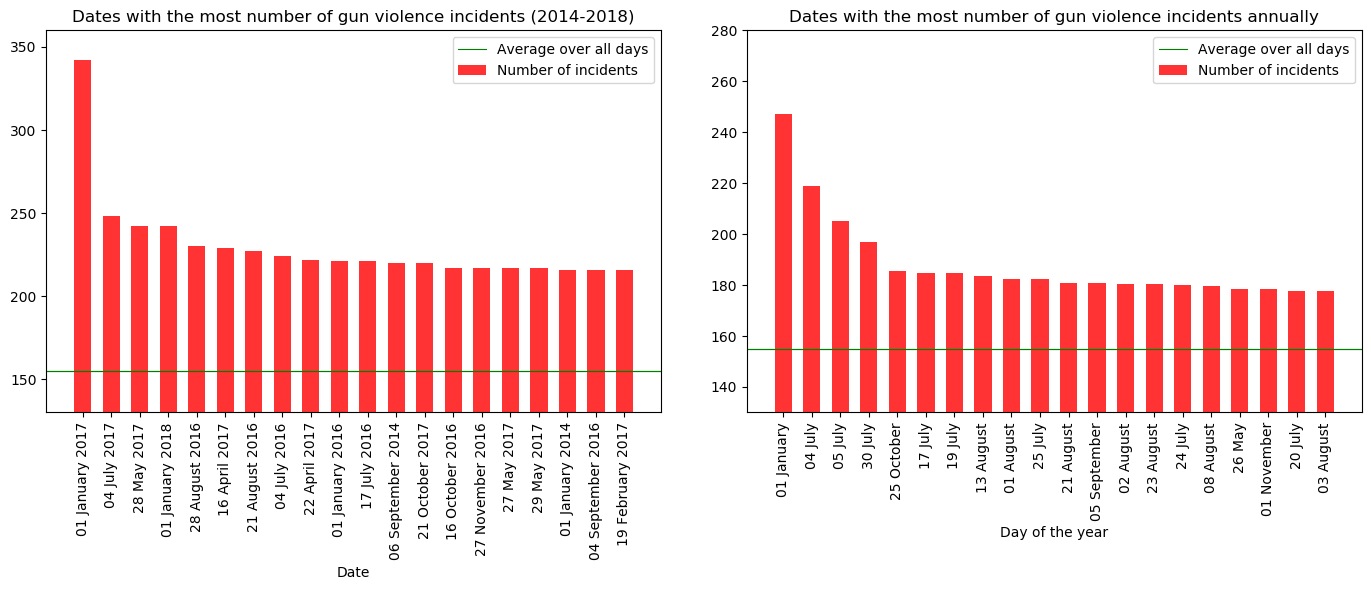

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].bar(np.arange(20), [x[1] for x in take(20, n_incidents_by_date.items())], alpha=0.8, label='Number of incidents', width=0.6, align='center', color='red')
ax[1].bar(np.arange(20), [x[1] for x in take(20, n_avg_incidents_by_date.items())], alpha=0.8, label='Number of incidents', width=0.6, align='center', color='red')
ax[0].axhline(sum(n_avg_incidents_by_date.values()) / 366, color='green', linestyle='-', linewidth=0.8)
ax[1].axhline(sum(n_avg_incidents_by_date.values()) / 366, color='green', linestyle='-', linewidth=0.8)
ax[0].axhline(sum(n_avg_incidents_by_date.values()) / 366, label='Average over all days', color='green', linestyle='-', linewidth=0.8)
ax[1].axhline(sum(n_avg_incidents_by_date.values()) / 366, label='Average over all days', color='green', linestyle='-', linewidth=0.8)
ax[0].set_xlabel("Date")
ax[1].set_xlabel("Day of the year")
ax[0].set_title("Dates with the most number of gun violence incidents (2014-2018)")
ax[1].set_title("Dates with the most number of gun violence incidents annually")
ax[0].set_ylim([130, 360])
ax[1].set_ylim([130, 280])
plt.sca(ax[0])
plt.xticks(np.arange(20), ['{0:%d} {0:%B} {0:%Y}'.format(x[0], "day", "month", "year") for x in take(20, n_incidents_by_date.items())], rotation=90)
plt.legend(loc='upper right')
plt.sca(ax[1])
plt.xticks(np.arange(20), ['{0:%d} {0:%B}'.format(x[0], "day", "month") for x in take(20, n_avg_incidents_by_date.items())], rotation=90)
plt.legend(loc='upper right')
fig.tight_layout()
plt.show()

### Gun crime statistics on federal holidays and weekends

In [84]:
n_incidents_by_weekday = pd.DataFrame(data.groupby(data.date.dt.weekday).count().loc[:, "date"])
n_incidents_by_weekday = n_incidents_by_weekday // n_records_by_date.groupby(n_records_by_date.index.get_level_values(3)).count()

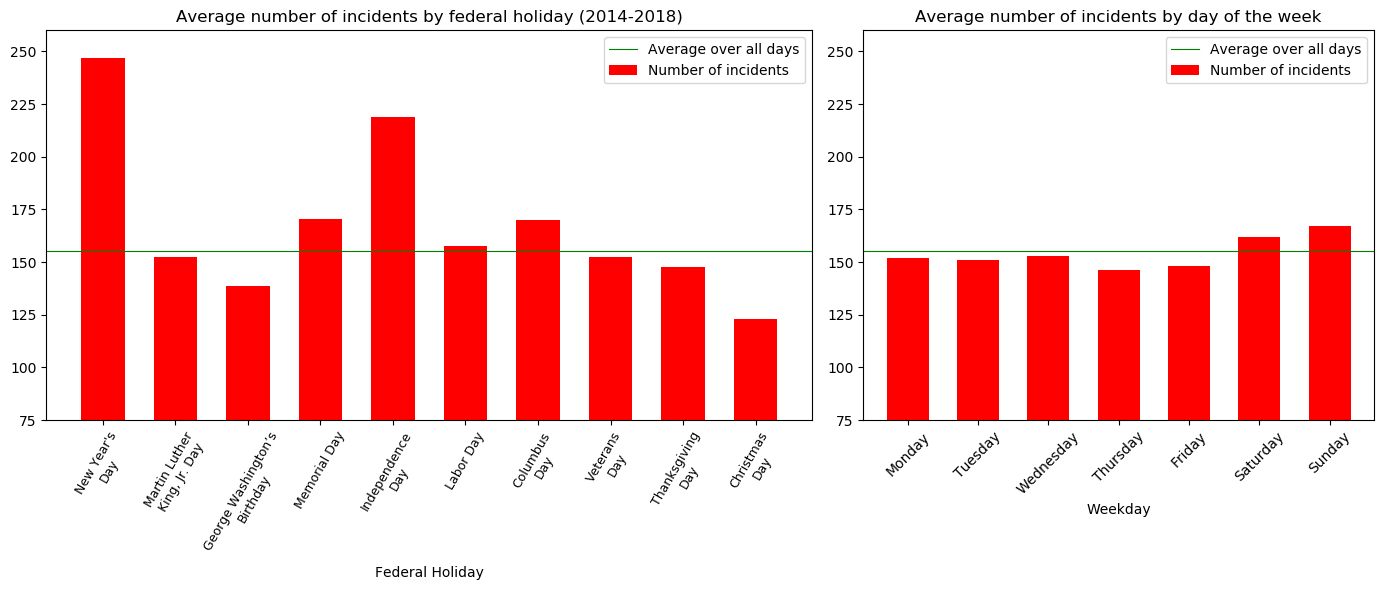

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1.5, 1]})
ax[0].bar(np.arange(len(holidays)), [n_avg_incidents_by_date[v] for k, v in holidays.items()], label='Number of incidents', width=0.6, align='center', color='red')
ax[1].bar(np.arange(len(weekdays)), [x[1] for x in n_incidents_by_weekday["date"].items()], label='Number of incidents', width=0.6, align='center', color='red')
ax[0].axhline(sum(n_avg_incidents_by_date.values()) / 366, label='Average over all days', color='green', linestyle='-', linewidth=0.8)
ax[1].axhline(sum(n_avg_incidents_by_date.values()) / 366, label='Average over all days', color='green', linestyle='-', linewidth=0.8)
ax[0].set_xlabel("Federal Holiday")
ax[1].set_xlabel("Weekday")
ax[0].set_title("Average number of incidents by federal holiday (2014-2018)")
ax[1].set_title("Average number of incidents by day of the week")
ax[0].set_ylim([75, 260])
ax[1].set_ylim([75, 260])
plt.sca(ax[0])
plt.xticks(range(0, len(holidays)), ["New Year's\nDay", 'Martin Luther\nKing, Jr. Day', 'George Washington’s\nBirthday', 'Memorial Day', 'Independence\nDay', 'Labor Day', 'Columbus\nDay', 'Veterans\nDay', 'Thanksgiving\nDay', 'Christmas\nDay'], rotation=60, fontsize = 9)
plt.legend(loc='upper right')
plt.sca(ax[1])
plt.xticks(range(0, 7), weekdays, rotation=45)
plt.legend(loc='upper right')
fig.tight_layout()
plt.show()

## State

In [86]:
#Hack to fix missing PROJ4 env var
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase

In [87]:
states = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "District of Columbia", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]
state_abbreviations = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
state_population = {'Alabama': 4853193, 'Alaska': 738438, 'Arizona': 6839353, 'Arkansas': 2979818, 'California': 38893516, 'Colorado': 5446126, 'Connecticut': 3585952, 'District of Columbia': 940788, 'Delaware': 674093, 'Florida': 20250908, 'Georgia': 10188251, 'Hawaii': 1419621, 'Idaho': 1659273, 'Illinois': 12852933, 'Indiana': 6612724, 'Iowa': 3119893, 'Kansas': 2905172, 'Kentucky': 4427480, 'Louisiana': 4656533, 'Maine': 1330774, 'Maryland': 5979634, 'Massachusetts': 6792551, 'Michigan': 9940970, 'Minnesota': 5487856, 'Mississippi': 2989215, 'Missouri': 6072902, 'Montana': 1031982, 'Nebraska': 1891988, 'Nevada': 2871365, 'New Hampshire': 1337613, 'New Jersey': 8871814, 'New Mexico': 2091906, 'New York': 19635618, 'North Carolina': 10047620, 'North Dakota': 744586, 'Ohio': 11619306, 'Oklahoma': 3900162, 'Oregon': 4028386, 'Pennsylvania': 12785093, 'Rhode Island': 1056172, 'South Carolina': 4891931, 'South Dakota': 856293, 'Tennessee': 6595774, 'Texas': 27442726, 'Utah': 2992711, 'Vermont': 624959, 'Virginia': 8360838, 'Washington': 7179800, 'West Virginia': 1838663, 'Wisconsin': 5763068, 'Wyoming': 582713}

In [46]:
# Map plotting constants
AREA_1 = 0.005  # exclude small Hawaiian islands that are smaller than AREA_1
AREA_2 = AREA_1 * 30.0  # exclude Alaskan islands that are smaller than AREA_2
AK_SCALE = 0.19  # scale down Alaska to show as a map inset
HI_OFFSET_X = -1900000  # X coordinate offset amount to move Hawaii "beneath" Texas
HI_OFFSET_Y = 250000    # similar to above: Y offset for Hawaii
AK_OFFSET_X = -250000   # X offset for Alaska (These four values are obtained
AK_OFFSET_Y = -750000   # via manual trial and error, thus changing them is not recommended.)

# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# Mercator projection, for Alaska and Hawaii
m_ = Basemap(llcrnrlon=-190,llcrnrlat=20,urcrnrlon=-143,urcrnrlat=46,
            projection='merc',lat_ts=20)

In [99]:
n_casualties_per_state = data.groupby("state").sum()["n_injured"] + data.groupby("state").sum()["n_killed"]
n_incidents_per_state = data.groupby("state").count()["date"]
 
n_casualties_per_capita = {state: round(n_casualties_per_state[state]*100000/state_population[state], 1) for state in states}
n_incidents_per_capita = {state: round(n_incidents_per_state[state]*100000/state_population[state], 1) for state in states}

In [49]:
def plot_map(values, vmin, vmax, title, legend_label):
    fig, ax = plt.subplots(figsize=(15, 10))

    #%% ---------   draw state boundaries  ----------------------------------------
    ## data from U.S Census Bureau
    ## http://www.census.gov/geo/www/cob/st2000.html
    shp_info = m.readshapefile('st99_d00','states',drawbounds=True,
                               linewidth=0.45,color='gray')
    shp_info_ = m_.readshapefile('st99_d00','states',drawbounds=False)

    #%% -------- choose a color for each state based on population density. -------
    colors={}
    statenames=[]
    cmap = plt.cm.PRGn_r
    norm = Normalize(vmin=vmin, vmax=vmax)
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        if statename not in ['District of Columbia','Puerto Rico']:
            ncpc = values[statename]
            colors[statename] = cmap(np.sqrt((ncpc-vmin)/(vmax-vmin)))[:3]
        statenames.append(statename)

    #%% ---------  cycle through state names, color each one.  --------------------
    for nshape, seg in enumerate(m.states):
        # skip DC and Puerto Rico.
        if statenames[nshape] not in ['Puerto Rico', 'District of Columbia']:
            color = rgb2hex(colors[statenames[nshape]])
            poly = Polygon(seg, facecolor=color, edgecolor=color)
            ax.add_patch(poly)

    for nshape, shapedict in enumerate(m_.states_info):  # plot Alaska and Hawaii as map insets
        if shapedict['NAME'] in ['Alaska', 'Hawaii']:
            seg = m_.states[int(shapedict['SHAPENUM'] - 1)]
            if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > AREA_1:
                seg = [(x + HI_OFFSET_X, y + HI_OFFSET_Y) for x, y in seg]
                color = rgb2hex(colors[statenames[nshape]])
            elif shapedict['NAME'] == 'Alaska' and float(shapedict['AREA']) > AREA_2:
                seg = [(x*AK_SCALE + AK_OFFSET_X, y*AK_SCALE + AK_OFFSET_Y)\
                       for x, y in seg]
                color = rgb2hex(colors[statenames[nshape]])
            poly = Polygon(seg, facecolor=color, edgecolor='gray', linewidth=.45)
            ax.add_patch(poly)
            
    #%% ---------  Plot bounding boxes for Alaska and Hawaii insets  --------------
    light_gray = [0.8]*3  # define light gray color RGB
    x1,y1 = m_([-190,-183,-180,-180,-175,-171,-171],[29,29,26,26,26,22,20])
    x2,y2 = m_([-180,-180,-177],[26,23,20])  # these numbers are fine-tuned manually
    m_.plot(x1,y1,color=light_gray,linewidth=0.8)  # do not change them drastically
    m_.plot(x2,y2,color=light_gray,linewidth=0.8)

    ###---------------------------------------------------------------------------

    ax.set_title(title)

    # Colour bar
    ax_c = fig.add_axes([0.92, 0.1, 0.03, 0.8])
    cb = ColorbarBase(ax_c,cmap=cmap,norm=norm,orientation='vertical',
                      label=legend_label)

    plt.show()

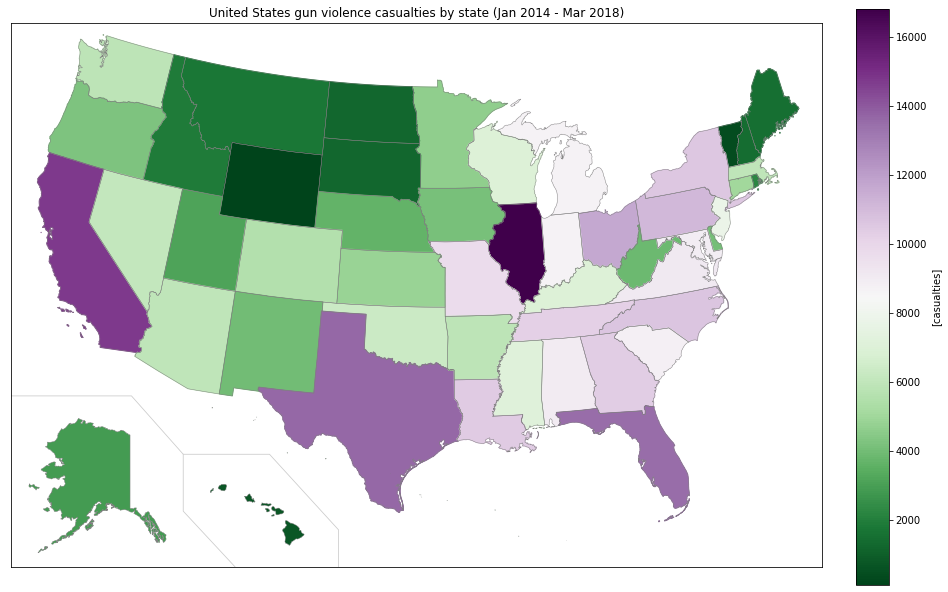

In [50]:
plot_map(nr_casualties_per_state, min(nr_casualties_per_state.values()), max(nr_casualties_per_state.values()), 'United States gun violence casualties by state (Jan 2014 - Mar 2018)', '[casualties]')

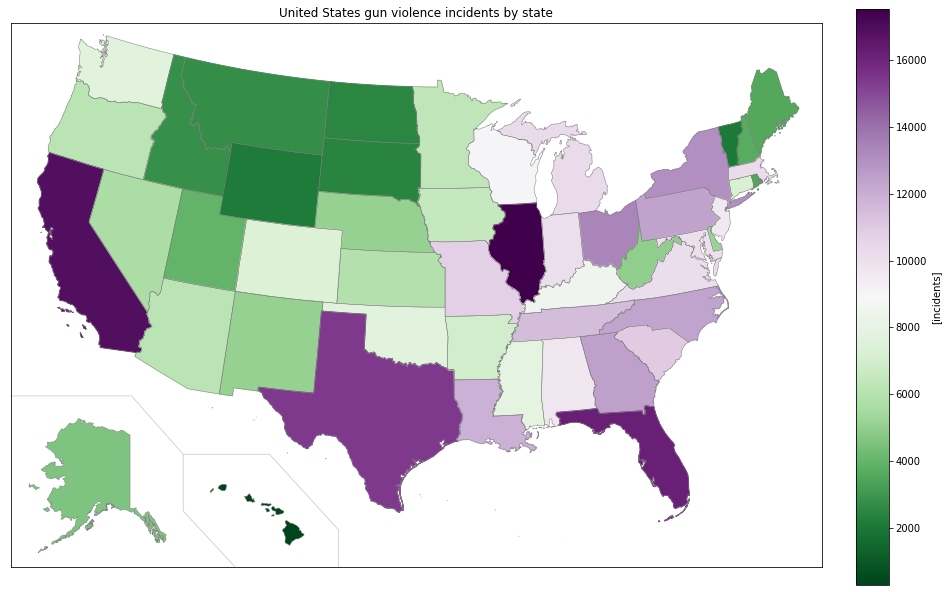

In [51]:
plot_map(nr_incidents_per_state, min(nr_incidents_per_state.values()), max(nr_incidents_per_state.values()), 'United States gun violence incidents by state', '[incidents]')

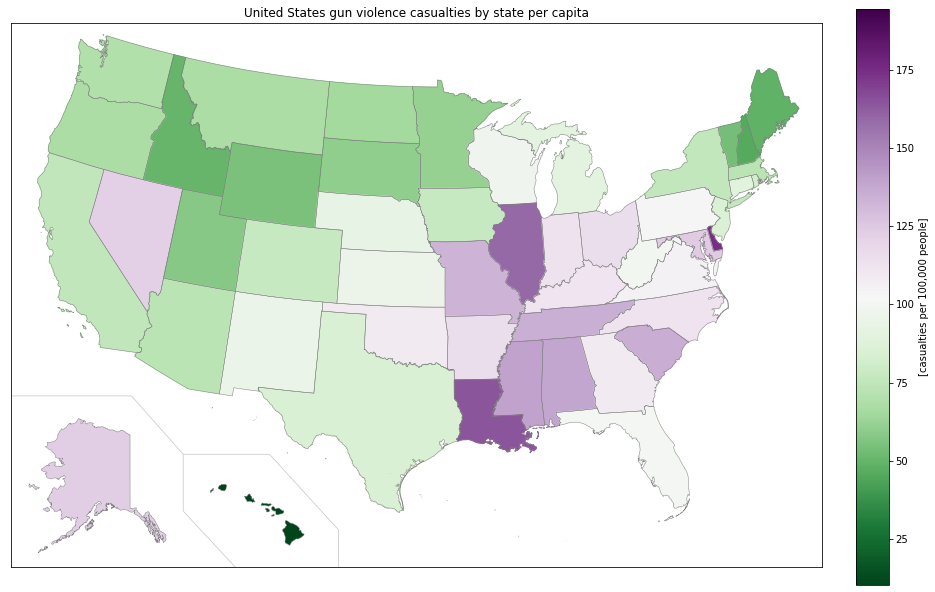

In [52]:
plot_map(nr_casualties_per_capita, min(nr_casualties_per_capita.values()), max(nr_casualties_per_capita.values()), 'United States gun violence casualties by state per capita', '[casualties per 100,000 people]')

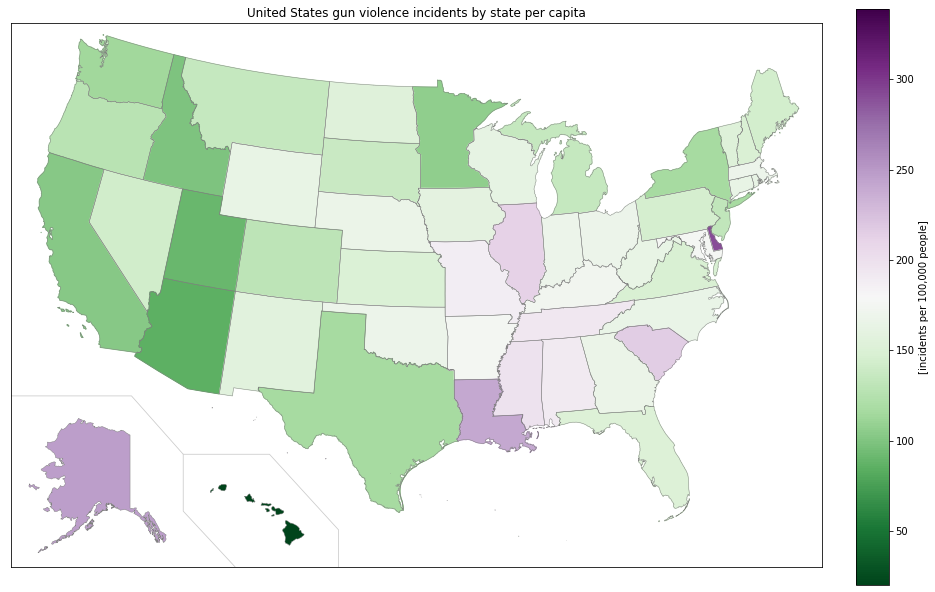

In [53]:
plot_map(nr_incidents_per_capita, min(nr_incidents_per_capita.values()), max(nr_incidents_per_capita.values()), 'United States gun violence incidents by state per capita', '[incidents per 100,000 people]')

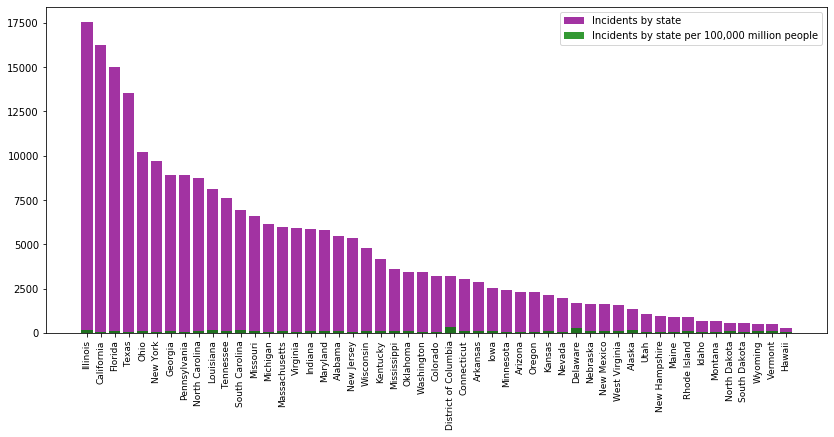

In [54]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(dict(sorted(nr_incidents_per_state.items(), key=lambda kv: kv[1], reverse=True)).keys(), dict(sorted(nr_incidents_per_state.items(), key=lambda kv: kv[1], reverse=True)).values(), label="Incidents by state", alpha=0.8, color="darkmagenta")
ax.bar(dict(sorted(nr_incidents_per_capita.items(), key=lambda kv: kv[1], reverse=True)).keys(), dict(sorted(nr_incidents_per_capita.items(), key=lambda kv: kv[1], reverse=True)).values(), label="Incidents by state per 100,000 million people", alpha=0.8, color="green")

plt.xticks(rotation=90, fontsize = 9)
plt.legend(loc='upper right')
plt.show()

## Cities

### Cities with most gun violence incidents

### Cities with most gun violence incidents per capita

### Map of gun violence incidents

## Address

### Addresses with most gun crimes

### Map with addresses with most gun violence, maybe coloured by state

## Nr killed/injured

### Pie chart with number of people killed/injured/casualties

### Maybe number of casualties over time

### Maybe incident characteristics/location description too

### Maybe gun type too

### Nr killed/injured by gender of suspect